In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from figaro.utils import rejection_sampler
from figaro.cosmology import dVdz_approx_planck18, Planck18 as Omega
import matplotlib.pyplot as plt
import os
from corner import corner

In [3]:
true_H0 = 70. # km/s/Mpc

In [4]:
# Mass distribution
from population_models.mass import plpeak

# Redshift distribution
def p_z(z):
    return dVdz_approx_planck18(z)/(1+z)

In [5]:
# Generate true detector frame mass samples
def generate_truth(n_SE_draws):
    M = rejection_sampler(n_SE_draws, plpeak, [0,200])
    z = rejection_sampler(n_SE_draws, p_z, [0, 2])
    return np.array([M * (1 + z), z]).T

In [6]:
# Generate detector frame mass posterior samples
def generate_mz_posterior_samples(truth, sigma = 0.03, n_samples = 1000):
    log_obs_mean = np.log(truth) + np.random.normal(0, sigma, truth.shape) # shape = (n_events)
    return np.exp(np.random.normal(log_obs_mean, sigma, (n_samples, len(truth)))).T # shape = (n_events, n_samples)

In [7]:
from selection_function import selection_function

n_SE_draws = 1_000_000
outdir = 'hierarchical_SE_test'
if not os.path.exists(outdir):
    os.makedirs(outdir)

samples = generate_truth(n_SE_draws) # shape = (n_events, n_params)
samples_SE = samples[np.random.uniform(0,1,samples.shape[0]) <= selection_function(samples[:,0],Omega.LuminosityDistance(samples[:,1]))] # shape = (n_events, n_params)
posterior = generate_mz_posterior_samples(samples_SE[:,0]) # shape = (n_events, n_samples)

samples.shape, posterior.shape

/Users/thomas.ng/Documents/GitHub/pop_models_lvk/population_models/mass.py:29: RuntimeWarning: divide by zero encountered in power
  p = m**-alpha * (alpha-1.)/(mmin**(1.-alpha)-mmax**(1.-alpha))
/Users/thomas.ng/Documents/GitHub/pop_models_lvk/population_models/mass.py:10: RuntimeWarning: overflow encountered in exp
  p[idx]       = 1./(1.+np.exp(exponent))


((1000000, 2), (1997, 1000))

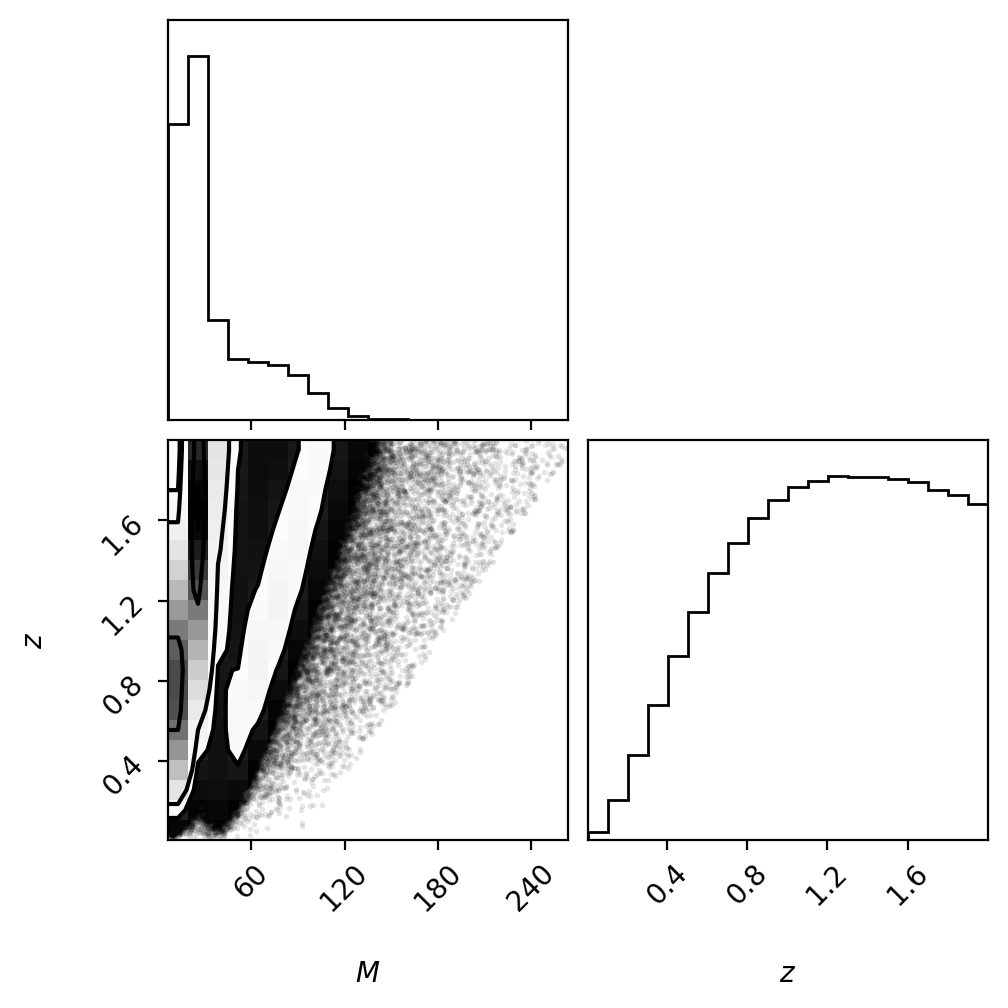

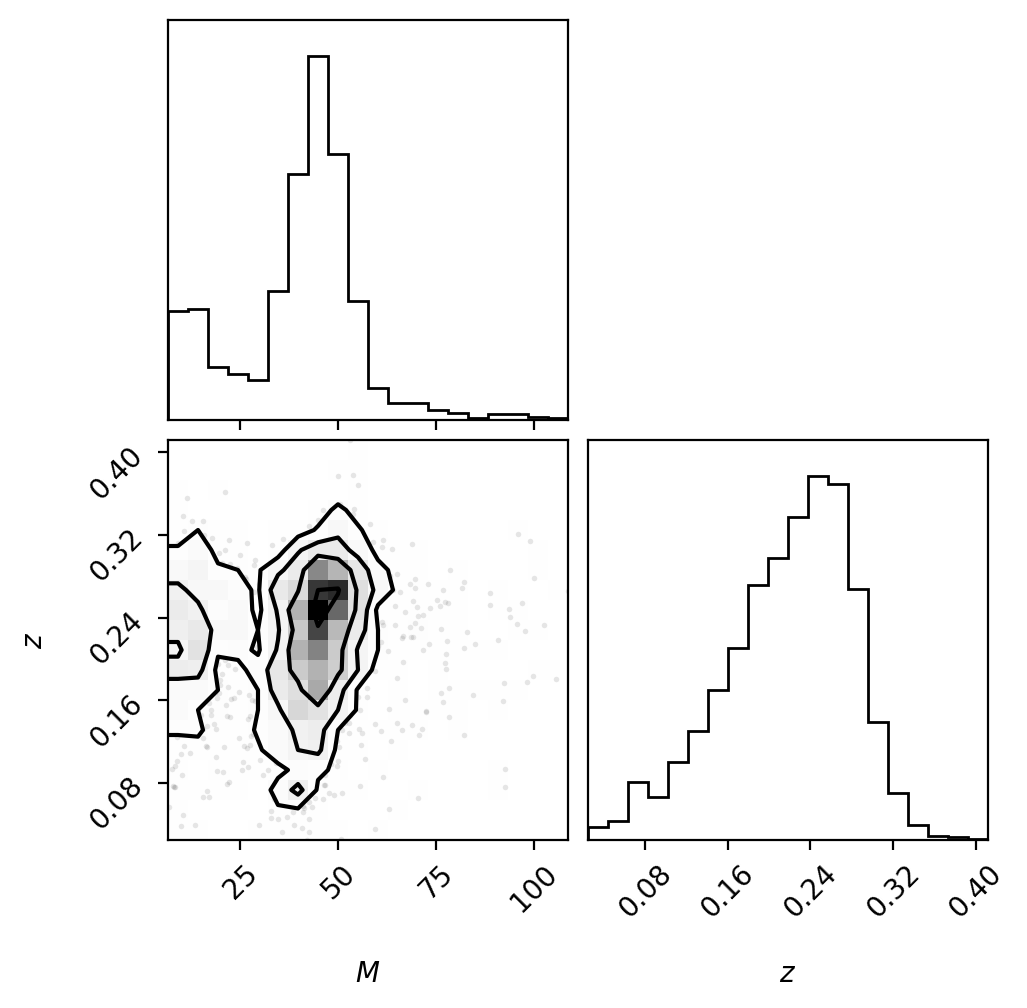

In [8]:
corner(samples, labels=['$M$', '$z$'])
plt.show()
corner(samples_SE, labels=['$M$', '$z$'])
plt.show()

In [9]:
posterior.max()

123.1080541289082

In [10]:
np.savetxt(outdir+'/true_samples.txt', samples[:,0])
np.savetxt(outdir+'/obs_samples.txt', samples_SE[:,0])
np.savetxt(outdir+'/jsd_bounds.txt', [np.median(posterior, axis=1).min(), np.median(posterior, axis=1).max()])

In [11]:
if not os.path.exists(outdir+'/data'):
    os.makedirs(outdir+'/data')
for i,p in enumerate(posterior):
    np.savetxt(f'{outdir}/data/posterior_samples_{i+1}.txt', p)